# Analysis of frequencies of CpG bias in various organisms

## Inspired by:

[Extreme Genomic CpG Deficiency in SARS-CoV-2 and Evasionof Host Antiviral Defense](https://academic.oup.com/mbe/advance-article/doi/10.1093/molbev/msaa094/5819559)

[Compositional Biases of Bacterial Genomes and Evolutionary Implications](https://jb.asm.org/content/jb/179/12/3899.full.pdf)

## Introduction

This is a simple project for learning how to do some bioinformatics, use git and github better and get a better understanding of biopython and the practicality of doing something like this in python.

I conclude that I can probably find faster tools to do the same project in R or in Galaxy.

In [1]:
#imports
import Bio
from Bio import SeqIO
from Bio.Seq import Seq

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#this script holds a set of useful functions I have built for this analysis
import cpg_functions

from random import choices
from collections import Counter

%matplotlib inline

# Genomes used in this project
These genomes are picked essentially arbitrarily. Some are from the papers. D. radiodurans is an extremophile that I find interesting. It handles very high levels of radiation.  
I did try to pick genomes that would be representative of different environmental niches. Of course the coronaviruses are all human pathogens of the lungs (and gut) while E. coli K12 is an attenuated strain recovered from a patient's stool. B. subtilis, and M. genitalium are similarly common pathogens but are not closely related to E. coli or each other. P. aerophilum is an archaea and so is genetically distant to all bacteria here.  
Keep in mind the viral genomes here are all of RNA viruses. The sequence here is the DNA equivalent of these, not the actual RNA sequence (which substitutes U for T). The original sequence seen by the sequencing machine would have been the cDNA template generated by reverse transcribing the RNA genome.
### Organisation of data
The genomes are read into memory using the biopython `SeqIO` module. For *D. radiodurans* the file contains 4 records (2 chromosomes, 2 plasmids) which requires the use of `SeqIO.parse` while the rest are a single record in `fasta` or `genbank` files. These are loaded into a dictionary object so it is trivial to use in a loop while allowing for descriptive keys for each sequence record.


In [2]:
#d. radiodurans has 4 sequences: 2 chromosomes and 2 plasmids
#parse and convert to list 
D_rad_genomes = list(SeqIO.parse("sequences/deinococcus_radiodurans_ref.fna", "fasta"))

#easiest to refer to these in a dict:
genomes = {'covid-19': SeqIO.read("sequences/covid19ref.gb", "genbank"), 
           'betacoronavirus-1':SeqIO.read("sequences/betacorona1ref.gb", "genbank"),
           'corona-HKU1':SeqIO.read("sequences/coronaHKU1ref.gb", "genbank"),
           'corona-l63': SeqIO.read("sequences/coronanl63_ref.gb", "genbank"),
           'E. coli' : SeqIO.read("sequences/ecoli_k12_ref.fasta", "fasta"),
           'B. subtilis' : SeqIO.read("sequences/bsubtilis.fasta", "fasta"),
           'D. radiodurans chr1' : D_rad_genomes[0],
           'D. radiodurans chr2' : D_rad_genomes[1],
           'D. radiodurans plasmid 1' : D_rad_genomes[2],
           'D. radiodurans plasmid 2' : D_rad_genomes[3],
           'M. genitalium' : SeqIO.read("sequences/Mycoplasma_genitalium_ref.gbff", "genbank"),
           'P. aerophilum' : SeqIO.read("sequences/Pyrobaculum_aerophilum_ref.gbff", "genbank"),
           'HIV-1' : SeqIO.read('sequences/HIV1_ref.fna', "fasta"),
           'HIV-2' : SeqIO.read('sequences/HIV2_ref.fna', "fasta")
           }

# Nucleotide frequencies in each genome
I am primarily interested in the single nucleotide and dinucleotide frequencies of each genome. The below cell will acquire these frequencies from each genome and produce two dictionaries with the same keys as the `genomes` dictionary. `singles` contains the single nucleotide frequencies and `doubles` contains the dinucleotide frequencies.

In [3]:
#get frequencies for each genome
genome_singles = {}
genome_doubles = {}
for key in genomes:
    genome_singles[key] = cpg_functions.windowed_base_count(sequence = genomes[key], k_window = 1)
    genome_doubles[key] = cpg_functions.windowed_base_count(sequence = genomes[key], k_window = 2)

def ratio_tables(singles, doubles):
    #get frequency of single bases as ratio of total bases
    genome_singles_ratio = {}
    for key in singles:
        total = sum(singles[key].values())
        temp_ratio_results = {}
        for base in ['A','T','C','G']:
            temp_ratio_results[base] = singles[key][base]/total
        genome_singles_ratio[key] = temp_ratio_results
        
    singles_table = pd.DataFrame(genome_singles_ratio)

    #do the same with double bases
    genome_doubles_ratio = {}
    for key in doubles:
        total = sum(doubles[key].values())
        temp_ratio_results = {}
        for base in doubles[key]:
            temp_ratio_results[base] = doubles[key][base]/total        
        genome_doubles_ratio[key] = temp_ratio_results
        
    doubles_table = pd.DataFrame(genome_doubles_ratio)
    return singles_table, doubles_table
singles_table, doubles_table = ratio_tables(genome_singles, genome_doubles)
#transpose for usefulness with pandas functions
singles_table = singles_table.T
doubles_table = doubles_table.T

# Single nucleotide frequencies in each genome
Lets consider the single nucleotide frequencies first. The table below is of ratios of each single base compared to the total bases. The sum of each row is 1. We can see that frequencies vary a lot between different species here. The stronger colouring here is for larger numbers *in the row*, so for a given organism. We can see that A and T or C and G will have a darker tone and the others a lighter tone. It makes sense that A and T, or C and G, would be correlated since they bind each other in the typical double stranded DNA structure (this is not true for the single stranded +RNA coronaviruses).  
  
The four coronavirus genomes all have much higher levels of A and T compared to C and G. While *E. coli*, *P. aerophilum*, and *B. subtilis* have an almost neutral spreads of frequencies. *D radiodurans* skews heavily into C and G bases, except for plasmid 1 which has the same bias, but with less strength. *M. genitalium*, another human pathogen, has bias towards A and T bases similar to the coronaviruses. 

In [16]:
#append AT ratio and CG ratio to table for reference here
singles_table.loc[:,'AT ratio'] = singles_table.apply(lambda x: x['A'] + x['T'], axis=1)
singles_table.loc[:,'CG ratio'] = singles_table.apply(lambda x: x['C'] + x['G'], axis=1)

#display a coloured table
cm = sns.light_palette("blue", as_cmap=True)
styled_singles = singles_table.style.background_gradient(cmap=cm, axis=1, subset=['A','T','C','G']) #only want single base freqs, not the summed ratios
styled_singles

,A,T,C,G,AT ratio,CG ratio
covid-19,0.299435,0.320837,0.183661,0.196067,0.620272,0.379728
betacoronavirus-1,0.276569,0.355551,0.151589,0.216291,0.632120,0.367880
corona-HKU1,0.278387,0.401023,0.130154,0.190436,0.679409,0.320591
corona-l63,0.263238,0.392153,0.144413,0.200196,0.655391,0.344609
E. coli,0.246193,0.245900,0.254239,0.253668,0.492093,0.507907
B. subtilis,0.281827,0.283029,0.218067,0.217077,0.564856,0.435144
D. radiodurans chr1,0.164755,0.164512,0.334980,0.335754,0.329266,0.670734
D. radiodurans chr2,0.169627,0.162721,0.333729,0.333923,0.332348,0.667652
D. radiodurans plasmid 1,0.218403,0.216069,0.284522,0.281005,0.434473,0.565527
D. radiodurans plasmid 2,0.183849,0.186374,0.314327,0.315450,0.370223,0.629777


# Dinucleotide frequencies in each genome
It is more challenging to draw the same kind of observations from the dinucleotide table. But it is clear that there is considerable variation in nucleotide frequencies between organisms. I note that *D. radiodurans* plasmid 1 seems to really stick out from the other components of the genome! I wonder if the plasmid is only an occasional visitor in *D. radiodurans*' genomes? Plasmid 1's sequence must have been under different selective pressures at least sometime recently (in evolutionary time).

In [7]:
doubles_coloured = doubles_table.style.background_gradient(cmap=cm, axis=1)
display(doubles_coloured)

,AT,TT,TA,AA,AG,GG,GT,AC,CC,CT,TC,CA,CG,GA,TG,GC
covid-19,0.077185,0.107518,0.079493,0.096315,0.058257,0.036553,0.066551,0.067654,0.029697,0.069594,0.047254,0.069694,0.014681,0.053909,0.086583,0.039061
betacoronavirus-1,0.093234,0.126708,0.090891,0.080709,0.059304,0.041802,0.078432,0.043299,0.026578,0.057189,0.038549,0.052049,0.015777,0.052895,0.099414,0.043169
corona-HKU1,0.103358,0.156859,0.107101,0.083977,0.051161,0.032515,0.081437,0.039900,0.019816,0.059382,0.041704,0.039566,0.011362,0.047753,0.095372,0.028739
corona-l63,0.086382,0.155052,0.090483,0.080938,0.046458,0.036694,0.088415,0.049470,0.021196,0.062319,0.041630,0.048817,0.012050,0.043010,0.105001,0.032085
E. coli,0.066776,0.073160,0.045679,0.072820,0.051278,0.058223,0.055088,0.055319,0.058561,0.050876,0.057608,0.070089,0.074713,0.057605,0.069454,0.082751
B. subtilis,0.081435,0.098885,0.051719,0.098511,0.055850,0.045589,0.046269,0.046031,0.045982,0.056440,0.065791,0.066642,0.049003,0.064956,0.066635,0.060263
D. radiodurans chr1,0.024086,0.033978,0.013335,0.033806,0.055369,0.097780,0.051542,0.051494,0.097328,0.054906,0.055495,0.061846,0.120900,0.055767,0.061704,0.130664
D. radiodurans chr2,0.024865,0.032681,0.013809,0.035289,0.055992,0.096414,0.049523,0.053480,0.095994,0.055650,0.053970,0.062828,0.119257,0.057701,0.062260,0.130286
D. radiodurans plasmid 1,0.041276,0.051340,0.028830,0.052329,0.065018,0.075228,0.054857,0.059767,0.075925,0.068599,0.067092,0.068048,0.071954,0.069183,0.068810,0.081742
D. radiodurans plasmid 2,0.030298,0.042017,0.017374,0.040491,0.060306,0.088482,0.055970,0.052756,0.087778,0.058091,0.060591,0.068185,0.100275,0.057800,0.066389,0.113199


# $I_{CpG}$ and $I*_{CpG}$ scores for each genome and the corresponding randomised genome
We are interested in the frequency of CpG sequences in these genomes, that is a Cytosine (C) followed by a guanine (G). The 'p' stands for the phosphate that connects each sequence. The frequency of C and G's need to be considered as well if we want to consider the frequency of CpG sequences.

The relative frequency of CpG sites compared to the proportion of the genome that is composed of Cs and Gs is called $I_{CpG}$. The formula is:

$I_{CpG} = \frac{P_{CpG}}{P_{C}*P_{G}}$

Where $P_{CpG}$ is the proportion of dinucleotides that are 'CG' and $P_{X}$ is the proportion of single nucleotides that are 'X'.

Nucleotide sequences are typically represented in a 3' to 5' direction and when comparing between genomes we cannot be certain the genomes are facing "in the same direction" although this is relative. To counter this, we can use the symmetrized version of $I_{CpG}$ which is $I*_{CpG}$ and accounts for the reverse compliment using set theory and the understanding that base frequency of A in the normal orientation is equal to the T base frequency in reverse compliment.

In [8]:
#calculate Icpg values and produce a table

icpg_dict = {'organism':[],'Icpg':[],'I*cpg':[], 'CG':[]}

for key in genomes:
    #calculate ICpG valuesIt's
    Icpg = cpg_functions.calculate_icpg(genome_singles[key], genome_doubles[key])
    Icpg_sym = cpg_functions.symmetrized_Icpg(genome_singles[key], genome_doubles[key])
    cg = (genome_singles[key]['C']+genome_singles[key]['G'])/sum(genome_singles[key].values())

    icpg_dict['organism'].append(key)
    icpg_dict['Icpg'].append(Icpg)
    icpg_dict['I*cpg'].append(Icpg_sym)
    icpg_dict['CG'].append(cg)

icpg_table = pd.DataFrame(icpg_dict)

#this manually appends a kingdom designation for each organism which is useful for our graph below
kingdom = {'covid-19':'virus', 'betacoronavirus-1':'virus', 'corona-HKU1':'virus', 'corona-l63':'virus', 
               'E. coli':'bacteria', 'B. subtilis':'bacteria', 'D. radiodurans chr1':'bacteria', 'D. radiodurans chr2':'bacteria', 
               'D. radiodurans plasmid 1':'bacteria', 'D. radiodurans plasmid 2':'bacteria', 'M. genitalium':'bacteria', 
               'P. aerophilum':'archaea', 'HIV-1':'virus', 'HIV-2':'virus'}
icpg_table.loc[:,'kingdom'] = icpg_table['organism'].map(kingdom)

## Table of $I_{CpG}$ and $I*_{CpG}$ scores
It is clear that the symmetrized version differs only very slightly from $I_{CpG}$. This is partly because that C and G bases often have similar proportions in the genome so the reverse compliment does not change the frequencies by much.

Colour coding the $I_{CpG}$ shows that the RNA viruses have lower scores than the bacterial genomes or the archaea, *P. aerophilum*.

In [9]:
cm_green = sns.light_palette("green", as_cmap=True)
icpg_table.style.background_gradient(cmap=cm_green, axis=0, subset=["Icpg","I*cpg","CG"])

,organism,Icpg,I*cpg,CG,kingdom
0,covid-19,0.407703,0.407267,0.379728,virus
1,betacoronavirus-1,0.481207,0.466322,0.367880,virus
2,corona-HKU1,0.458391,0.442184,0.320591,virus
3,corona-l63,0.416797,0.405875,0.344609,virus
4,E. coli,1.158483,1.158482,0.507907,bacteria
5,B. subtilis,1.035190,1.035185,0.435144,bacteria
6,D. radiodurans chr1,1.074949,1.074948,0.670734,bacteria
7,D. radiodurans chr2,1.070148,1.070148,0.667652,bacteria
8,D. radiodurans plasmid 1,0.899964,0.899929,0.565527,bacteria
9,D. radiodurans plasmid 2,1.011297,1.011294,0.629777,bacteria


## Graphing $I_{CpG}$ against %GC
The graph below is of $I*_{CpG}$ compared to percentage GC content of each organism. On the left, colouring is by organism, while on the right, colouring is by kingdom. In this tiny subset of all sequenced organism there is a clear grouping of viruses (and pathogenic *M. genitalium*) into a low $I_{CpG}$/low %GC content group, while the remaining bacteria and archaea have relatively high $I_{CpG}$ values and quite high GC content. HIV-1 appears to have the lowest $I_{CpG}$ value, while *E. coli* has the highest.

Text(0.5, 0.98, 'Density of CpG sites compared with percentage GC ')

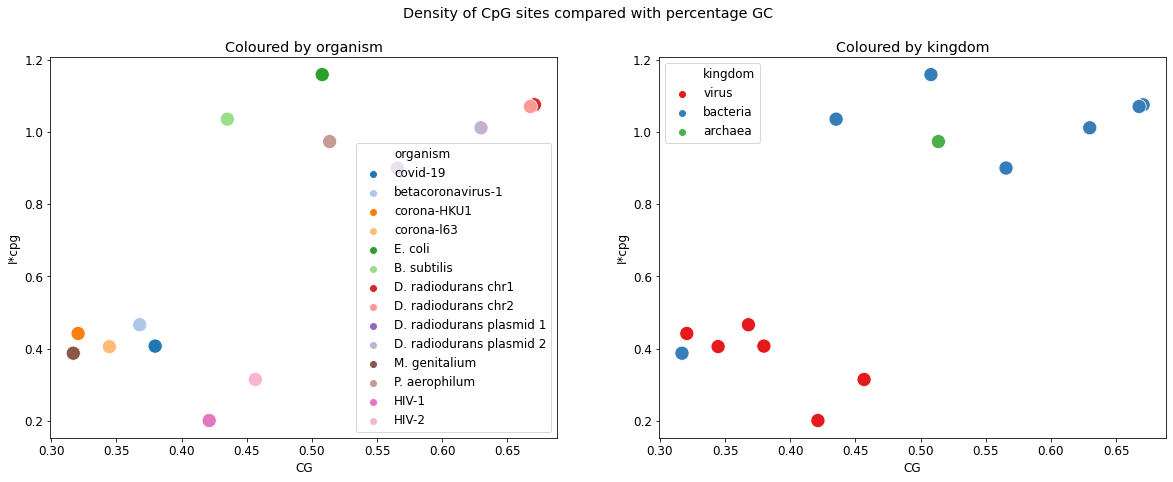

In [10]:
#set useful defaults for matplotlib font to get easier to read figures
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,7))

sns.scatterplot(x="CG", y="I*cpg", data=icpg_table, hue='organism', s=200, palette='tab20', ax=ax1)
sns.scatterplot(x="CG", y="I*cpg", data=icpg_table, hue='kingdom', s=200, palette='Set1', ax=ax2)

ax1.set_title('Coloured by organism')
ax2.set_title('Coloured by kingdom')

fig.suptitle('Density of CpG sites compared with percentage GC ')